# Conveccción de calor en 1D, NO estacionaria.

**Objetivo**.

Resolver por diferencias finitas el problema de convección de calor No estacionario para diferentes valores de la velocidad y diferentes esquemas numéricos.

 <p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/repomacti/macti/tree/main/notebooks/Analisis_Numerico_01">MACTI-Analisis_Numerico_01</a> by <a rel="cc:attributionURL dct:creator" property="cc:attributionName" href="https://www.macti.unam.mx">Luis M. de la Cruz</a> is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p> 

**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101922**

# Descripción del problema.

Considere el siguiente problema:

$$
\begin{eqnarray}
	\frac{\partial T}{\partial t} +
	u \frac{\partial T}{\partial x} -
	\alpha \frac{\partial^2 T}{\partial x^2} & = & Q \\
	T(0, t) & = & 1 \qquad \text{para} \qquad 0 < t < T_{max} \\
	T(L, t) & = & 0 \qquad \text{para} \qquad 0 < t < T_{max} \\
	T(x, 0) & = & 0 \qquad \text{para} \qquad 0 < x \leq L
\end{eqnarray}
$$

El dominio de estudio, las condiciones de frontera y la velocidad son como se muestran en la siguiente figura:

<img src="./conv03.png">


Implementar la solución numérica con diferencias finitas en Python con los siguientes datos: 
$L = 1.0$ [m], $c_p = 1.0$ [J / Kg $^\text{o}$K], $\rho = 1.0$ [kg/m$^3$], $\kappa = 0.1$ [kg/m s], $S = 0$ y 
para:

* $u = 0.1$ [m/s], con $6$ nodos.
* $u = 2.5$ [m/s], con $6$ nodos.
* $u = 2.5$ [m/s], con $20$ nodos.

En todos los casos comparar los esquemas de **diferencias centradas** y **upwind** para la
aproximación de la primera derivada.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import macti.visual as mvis

In [8]:
def mesh(L,N):
    x = np.linspace(0,L,N+2)
    return L/(N + 1), x

def plot_sol(x, T, xa, Ta):

    plt.plot(xa,Ta,'k-', lw = 2.0, label='Analítica')
    plt.scatter(x, T, zorder=5, s=100, fc='C1', ec='k', alpha=0.75, label='Numérica')
    plt.plot(x,T, '--', lw=1.0)

    plt.xlabel('x [m]')
    plt.ylabel('T')
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [13]:
def Laplaciano1D(A, f, N, h, ht, Gamma, u, T, esquema='CD'):

    if esquema == 'CD':
    ## Diferencias centradas
        b = -u / (2*h) + Gamma / h**2
        c =  u / (2*h) + Gamma / h**2 
        a = b + c
    elif esquema == 'UP':
    ## Upwind
        ce=max(-u/h,0)
        cw=max(u/h,0)
        b=ce+Gamma/h**2
        c=cw+Gamma/h**2
        a=b+c
        
    b = ht * (b + Gamma / h**2)
    c = ht * (c + Gamma / h**2) 
    a = b + c + 1
    
    # Matriz del sistema
    A[0,0] = a 
    A[0,1] = -b
    for i in range(1,N-1):
        A[i,i] = a 
        A[i,i+1] = -b
        A[i,i-1] = -c
    A[N-1,N-2] = -c
    A[N-1,N-1] = a

    # RHS del sistema
    f = np.copy(T[1:N+1])
    f[0]   += T[0] * c
    f[N-1] += T[-1] * b
    
    return A, f

In [14]:
def analytic_sol(par, NP = 100):
    L     = par['L']
    u     = par['u']
    Gamma = par['Gamma']
    t     = par['ht'] * par['Tmax']
    
    xa = np.linspace(0, L, NP)
    
    divisor = 2 * np.sqrt(Gamma * t)
    Ta = 0.5 * (special.erfc((xa - u * t)/ divisor) + 
                np.exp(u * xa) * np.exp(-Gamma) * special.erfc((xa + u * t)/divisor))
    return (xa, Ta)

In [17]:
def fdm_sol(par):
    L     = par['L']
    Gamma = par['Gamma']
    rho   = par['rho']
    u     = par['u']
    N     = par['N']
    T0    = par['BC'][0]
    TL    = par['BC'][1]
    h     = par['h']
    ht    = par['ht']
    Tmax  = par['Tmax']
    freq  = par['freq']
    
    T = np.zeros(N+2)
    T[0] = T0
    T[-1] = TL
    
    x = np.linspace(0,L,N+2)
    
    xa, Ta = analytic_sol(par,200)
    plt.figure(figsize=(10,5))
    plt.plot(xa, Ta, 'k-', lw = 2.0, label='Sol. exacta')
    
    A = np.zeros((N,N))
    f = np.zeros(N)
        
    for i in range(1, Tmax+1):
        A, f = Laplaciano1D(A, f, N, h, ht, Gamma, u, T, 'CD') # Matriz del sistema

        T[1:N+1] = np.linalg.solve(A,f)

        if (i % freq == 0):
            etiqueta = 'Time = {}'.format(i*ht)
            plt.plot(x, T, '.-', lw = 1.0, label=etiqueta)

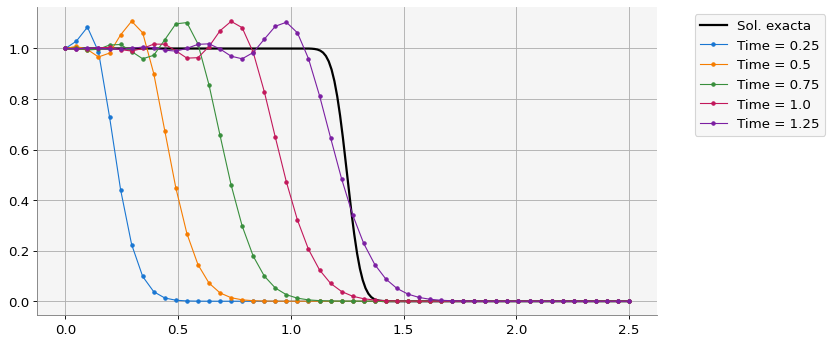

In [18]:
par = {}
par['L']     = 2.5 # m
par['rho']   = 1.0 # kg/m^3
par['u']     = 1.0 # m/s
par['Gamma'] = 0.001 # kg / m.s
par['BC']    = (1.0, 0.0)
par['N']     = 50 # Número de incógnitas
par['Tmax']  = 500
par['ht']    = 0.0025
par['freq']  = 100

h, x = mesh(par['L'], par['N'])

par['h'] = h


fdm_sol(par)

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()